In [2]:
# import necessary importa
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import pymysql
pymysql.install_as_MySQLdb()

from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists

from urllib.parse import quote_plus as urlquote

In [5]:
df_combined = pd.read_csv('Data/tmdb_results_combined.csv.gz')
df_combined.head()

True

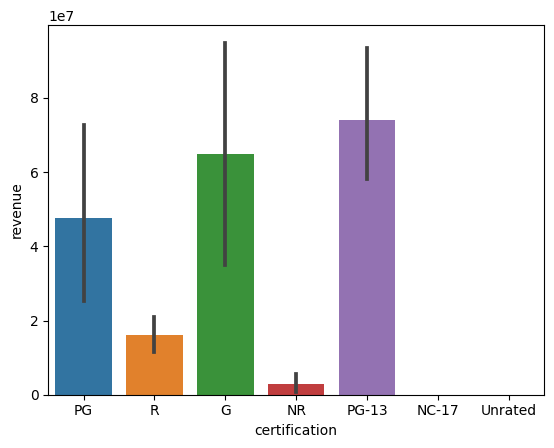

In [9]:
ax = sns.barplot(data=df_combined, x='certification', y='revenue', ci=95)


In [8]:
df_R = df_combined[df_combined['certification']== 'R']
df_PG_13 = df_combined[df_combined['certification']== 'PG-13']
df_NR = df_combined[df_combined['certification']== 'NR']
df_PG = df_combined[df_combined['certification']== 'PG']
df_G = df_combined[df_combined['certification']== 'G']
df_NC = df_combined[df_combined['certification']== 'NC-17']
df_Unrated = df_combined[df_combined['certification']== 'Unrated']